In [1]:
from PIL import Image
from tqdm import tqdm
import os
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from tensorflow.keras import layers, models

Let's start by examining the resolutions of a sample set of images.

In [2]:
# Your image directory
image_folder = '../img/images_100k/'

# Collect all .jpg or .jpeg files
image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder)
               if f.lower().endswith(('.jpeg'))]

# Initialize resolution bins
resolution_counts = Counter()

# Loop efficiently
for path in tqdm(image_files, desc="Processing JPEG images"):
    try:
        with Image.open(path) as img:
            w, h = img.size
            min_dim = min(w, h)  # use the smaller dimension to categorize

            if min_dim < 50:
                resolution_counts['<50'] += 1
            elif 50 <= min_dim < 100:
                resolution_counts['50-100'] += 1
            elif 100 <= min_dim < 150:
                resolution_counts['100-150'] += 1
            else:
                resolution_counts['>150'] += 1
    except Exception:
        resolution_counts['error'] += 1

# Print summary
print("\nJPEG Image Resolution Distribution:")
for category, count in resolution_counts.items():
    print(f"{category}: {count}")

Processing JPEG images: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 99982/99982 [00:17<00:00, 5861.06it/s]


JPEG Image Resolution Distribution:
50-100: 47007
100-150: 52919
<50: 56


In the following section, we apply basic unsupervised image clustering techniques (**CNN + PCA + KMeans**) to understand the data distribution, explore feature patterns, and assess whether visual similarity is meaningfully captured — all before developing a full image retrieval pipeline. **Clustering during the EDA stage provides high-level visual insight into the dataset and helps us identify any natural groupings or dominant patterns, which is especially valuable when no labels are available.**

We use a Convolutional Neural Network (CNN) to extract meaningful visual features from images. CNNs are effective at capturing spatial hierarchies — such as edges, textures, and shapes — which makes them well-suited for understanding visual similarity beyond raw pixel values. Each image is transformed into a compact feature vector that summarizes its visual content.

However, the feature vectors generated by CNNs are still high-dimensional, which can make subsequent analysis (like clustering) inefficient or noisy. To address this, we apply Principal Component Analysis (PCA) to reduce the dimensionality of these vectors while preserving the most important information. PCA simplifies the feature space, speeds up computation, and reduces noise or redundancy.

Finally, we pass the PCA-reduced feature vectors into the KMeans clustering algorithm, which groups similar images together based on their feature similarity. This allows us to explore natural groupings in the data and identify clusters of visually related images.

In the methods below, wer are loading and processing images in batches of 1000. This approach helps manage memory efficiently and prevents system from crashing when working with large datasets like 100,000 images.

Extracting features: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:51<00:00,  1.94it/s]


Total features shape: (99982, 64)

Cluster 0: 9486 images


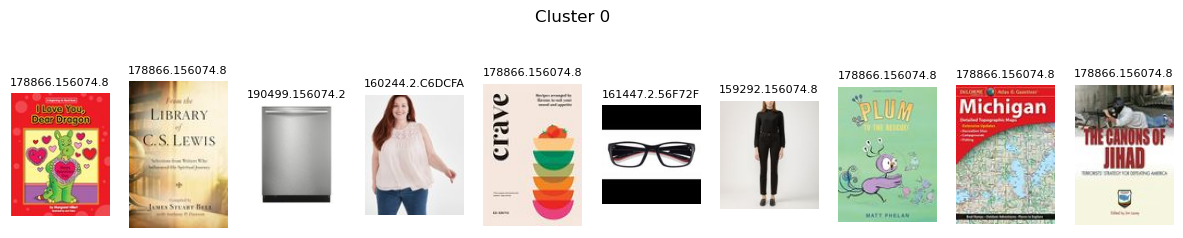


Cluster 1: 5280 images


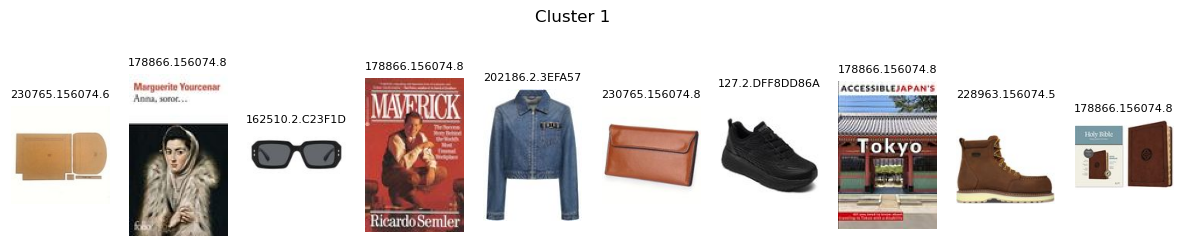


Cluster 2: 8177 images


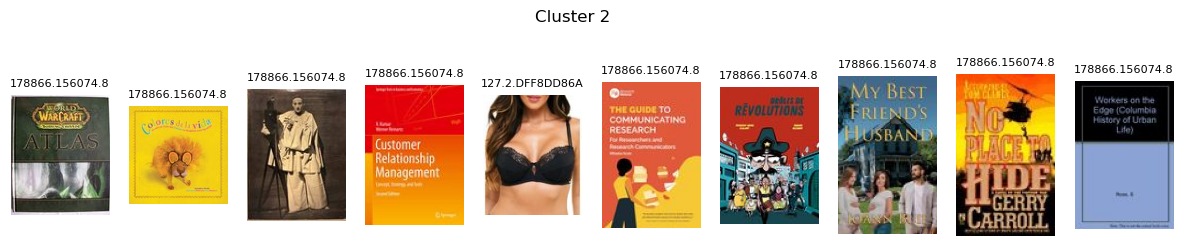


Cluster 3: 21843 images


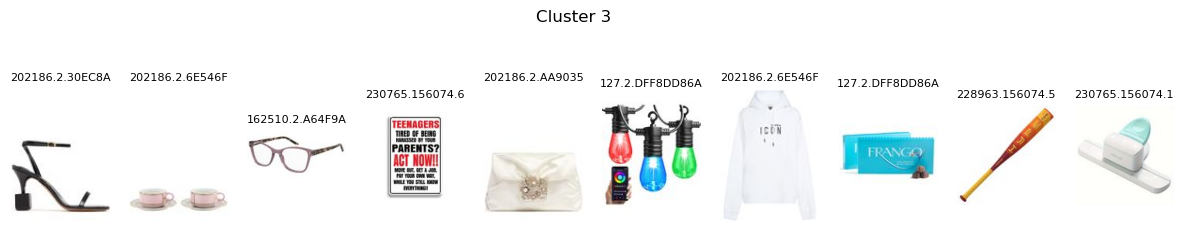


Cluster 4: 9027 images


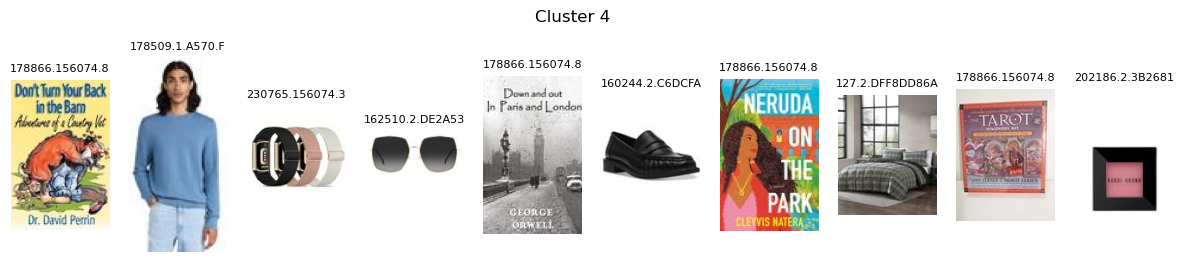


Cluster 5: 17120 images


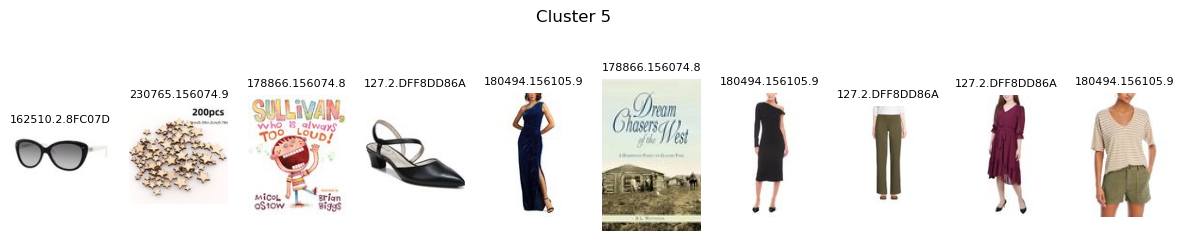


Cluster 6: 6974 images


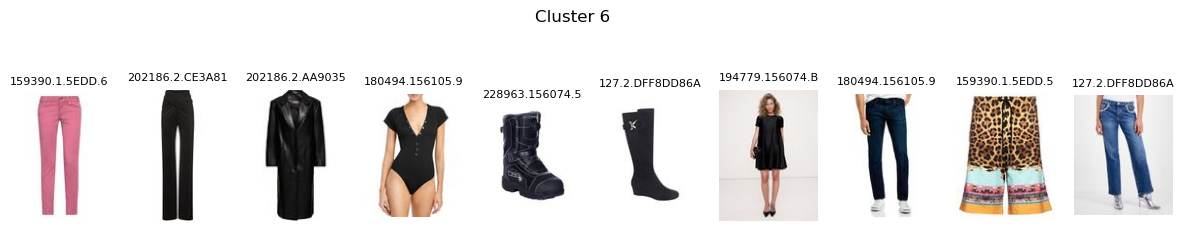


Cluster 7: 5379 images


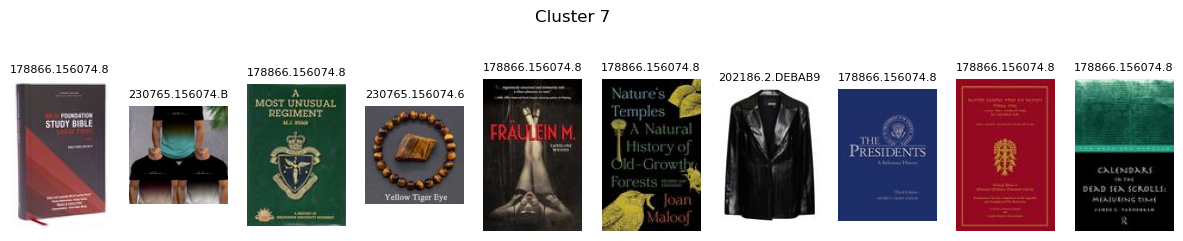


Cluster 8: 6037 images


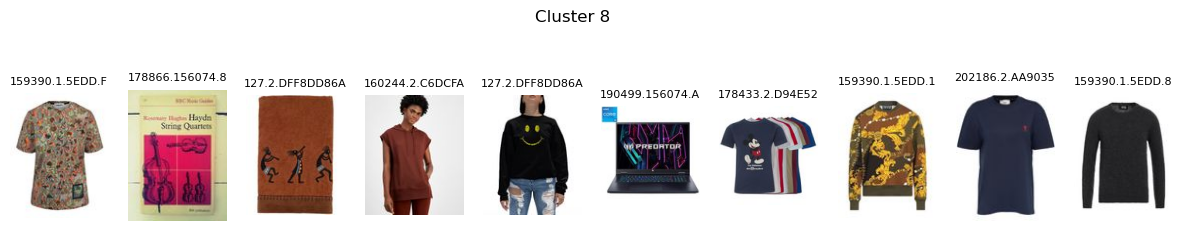


Cluster 9: 10659 images


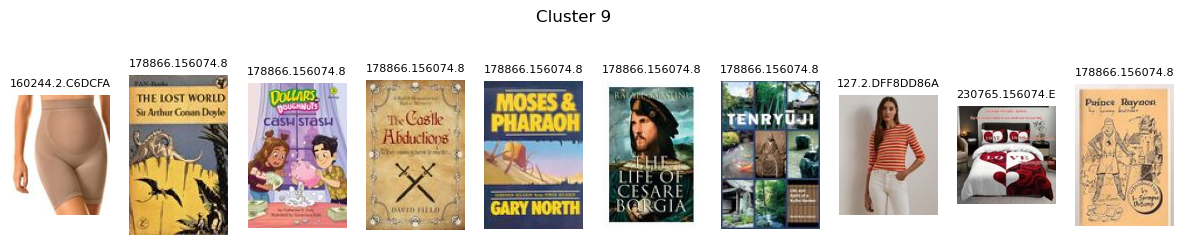

In [5]:
# ========== Step 1: Build CNN ==========
def build_feature_extractor(input_shape=(64, 64, 3)):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(16, (3, 3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(64, activation='relu')  # Feature vector
    ])
    return model

# ========== Step 2: Batch image loader ==========
def load_image_batch(image_paths, image_size=(64, 64)):
    images = []
    filenames = []
    for path in image_paths:
        try:
            img = Image.open(path).convert('RGB').resize(image_size)
            images.append(np.array(img) / 255.0)
            filenames.append(os.path.basename(path))
        except Exception as e:
            print(f"Error loading {path}: {e}")
    return np.array(images), filenames

# ========== Step 3: Extract features in batches ==========
def extract_features_in_batches(folder_path, batch_size=1000, image_size=(64, 64)):
    cnn_model = build_feature_extractor(input_shape=(64, 64, 3))
    all_features = []
    all_filenames = []

    image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.lower().endswith('.jpg') or f.lower().endswith('.jpeg')]
    for i in tqdm(range(0, len(image_files), batch_size), desc="Extracting features"):
        batch_paths = image_files[i:i + batch_size]
        batch_images, batch_names = load_image_batch(batch_paths, image_size=image_size)
        if len(batch_images) == 0:
            continue
        batch_features = cnn_model.predict(batch_images, batch_size=64, verbose=0)
        all_features.append(batch_features)
        all_filenames.extend(batch_names)

    return np.concatenate(all_features), all_filenames

# ========== Step 4: PCA ==========
def reduce_with_pca(features, n_components=50):
    pca = PCA(n_components=n_components, random_state=42)
    return pca.fit_transform(features)

# ========== Step 5: Clustering ==========
def cluster_features(features, n_clusters=10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    return kmeans.fit_predict(features)

# ========== Step 6: Visualization ==========
def show_cluster_samples(folder_path, filenames, labels, cluster_id, n_samples=10):
    indices = [i for i, l in enumerate(labels) if l == cluster_id][:n_samples]
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(indices):
        img_path = os.path.join(folder_path, filenames[idx])
        img = Image.open(img_path).convert('RGB')
        plt.subplot(1, n_samples, i+1)
        plt.imshow(img)
        plt.title(filenames[idx][:15], fontsize=8)
        plt.axis('off')
    plt.suptitle(f"Cluster {cluster_id}")
    plt.show()

# ========== Run the pipeline ==========
folder_path = '../img/images_100k/'
features, filenames = extract_features_in_batches(folder_path, batch_size=1000)
print(f"Total features shape: {features.shape}")

pca_features = reduce_with_pca(features, n_components=50)
labels = cluster_features(pca_features, n_clusters=10)

# Count number of images in each cluster
cluster_counts = Counter(labels)

# Loop through each cluster and display 10 samples
for cluster_id in range(10):  # For clusters 0 to 9
    print(f"\nCluster {cluster_id}: {cluster_counts[cluster_id]} images")
    show_cluster_samples(folder_path, filenames, labels, cluster_id=cluster_id, n_samples=10)

Based on the clustering results, Cluster 3 contains 21843 images, which is more than double the size of most other clusters. **This imbalance suggests that the clustering may be overly influenced by dominant low-level features such as color or general shape, rather than capturing more nuanced distinctions.** Since we did not fine-tune the CNN or perform supervised training, the feature extraction is relatively generic. As a result, the initial clustering may not fully reflect semantic groupings.

However, even with this basic unsupervised approach, **the model is still able to group images with visually similar characteristics — such as books, cloth, or items with similar colors and textures — indicating that the CNN is extracting some meaningful patterns.** This gives us a useful starting point for exploratory analysis and suggests that further improvement could be achieved with more advanced feature extraction or fine-tuning.

**Let's try using a pre-trained model to extract features.**

Since our sample images are all smaller than 150×150 pixels, we choose MobileNetV2 instead of a heavier model like ResNet50. MobileNetV2 is a lightweight and efficient convolutional neural network that allows us to run the pipeline faster on local machines while still extracting rich semantic features from images. These features can then be used for effective clustering and similarity analysis.

Extracting features: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [03:51<00:00,  1.16s/it]


Extracted features shape: (99982, 1280)

Cluster 0: 10950 images


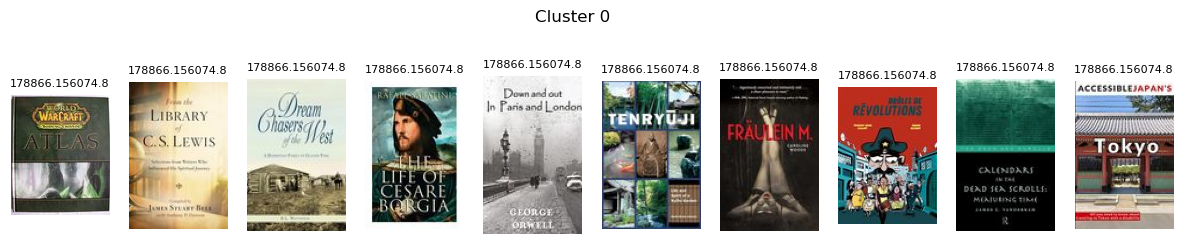


Cluster 1: 5797 images


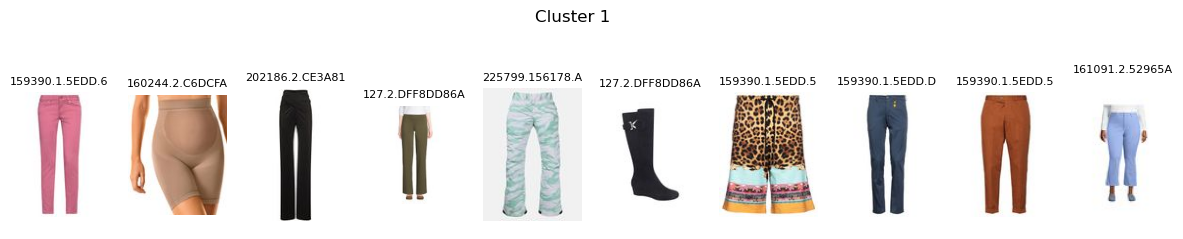


Cluster 2: 7474 images


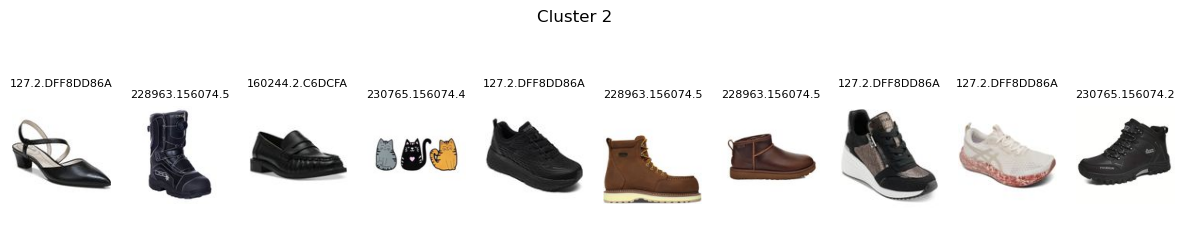


Cluster 3: 9728 images


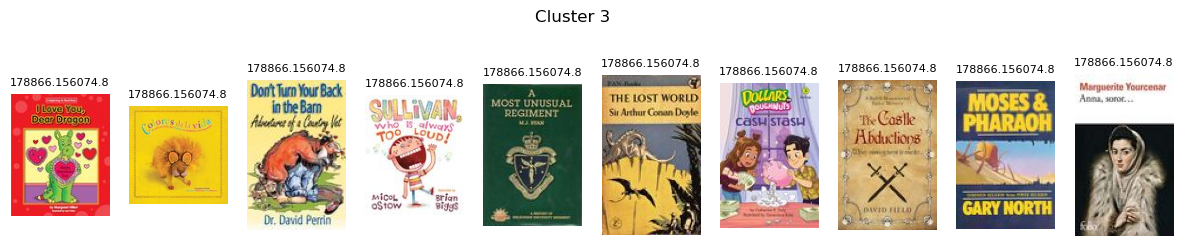


Cluster 4: 7903 images


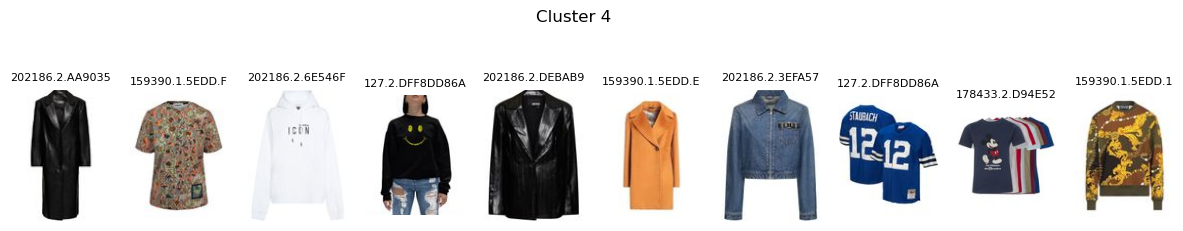


Cluster 5: 12545 images


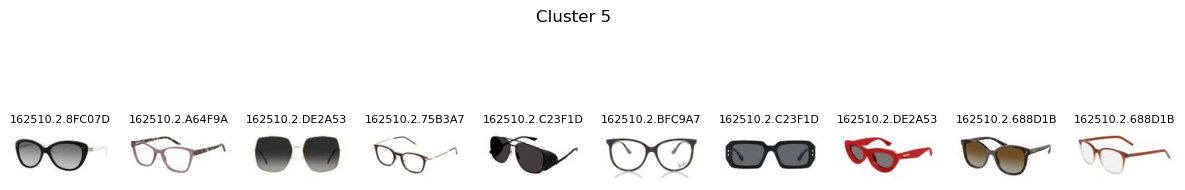


Cluster 6: 9545 images


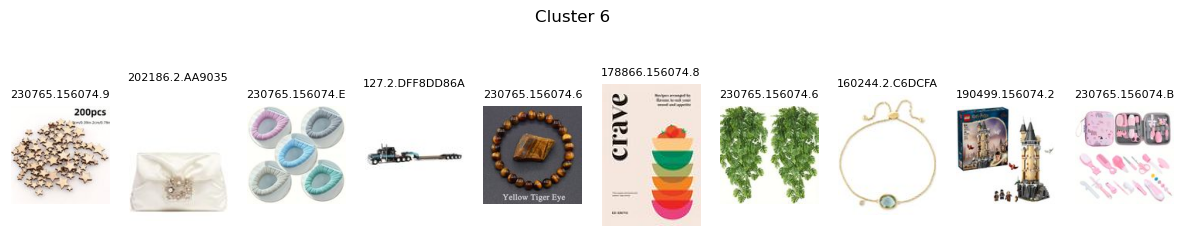


Cluster 7: 12315 images


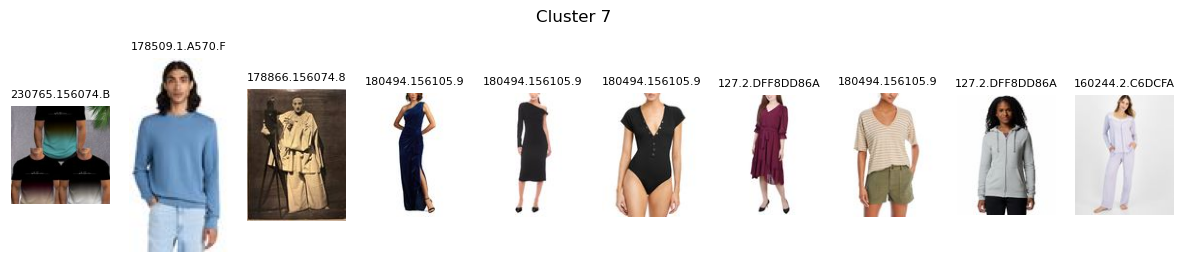


Cluster 8: 13721 images


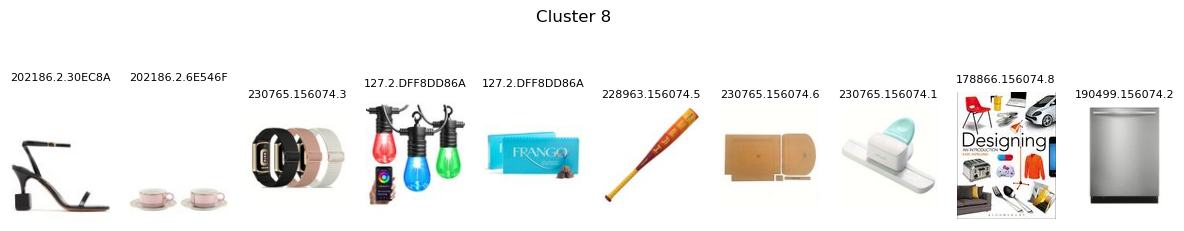


Cluster 9: 10004 images


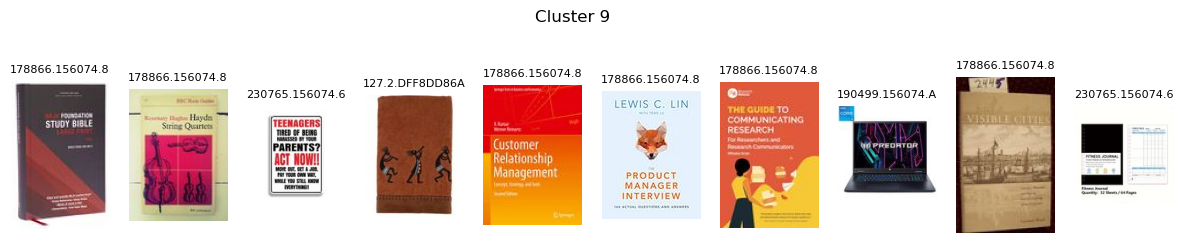

In [6]:
# ========== Step 1: Load Pretrained MobileNetV2 ==========
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

# Load MobileNetV2 with average pooling
base_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg', input_shape=(128, 128, 3))
model = Model(inputs=base_model.input, outputs=base_model.output)

# ========== Step 2: Preprocess and Extract Features ==========
def preprocess_mobilenet_image(img_path):
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array)

def extract_mobilenet_features_in_batches(folder_path, batch_size=500):
    all_features = []
    all_filenames = []
    image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path)
                   if f.lower().endswith(('.jpg', '.jpeg'))]

    for i in tqdm(range(0, len(image_files), batch_size), desc="Extracting features"):
        batch_paths = image_files[i:i + batch_size]
        batch_images = [preprocess_mobilenet_image(p) for p in batch_paths]
        batch_array = np.vstack(batch_images)
        batch_features = model.predict(batch_array, batch_size=64, verbose=0)
        all_features.append(batch_features)
        all_filenames.extend([os.path.basename(p) for p in batch_paths])

    return np.concatenate(all_features), all_filenames

# ========== Step 3: PCA ==========
def reduce_with_pca(features, n_components=50):
    pca = PCA(n_components=n_components, random_state=42)
    return pca.fit_transform(features)

# ========== Step 4: KMeans Clustering ==========
def cluster_features(features, n_clusters=10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    return kmeans.fit_predict(features)

# ========== Step 5: Show Sample Clusters ==========
def show_cluster_samples(folder_path, filenames, labels, cluster_id, n_samples=10):
    indices = [i for i, l in enumerate(labels) if l == cluster_id][:n_samples]
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(indices):
        img_path = os.path.join(folder_path, filenames[idx])
        img = Image.open(img_path).convert('RGB')
        plt.subplot(1, n_samples, i+1)
        plt.imshow(img)
        plt.title(filenames[idx][:15], fontsize=8)
        plt.axis('off')
    plt.suptitle(f"Cluster {cluster_id}")
    plt.show()

# ========== Step 6: Run the Pipeline ==========
folder_path = '../img/images_100k/'
features, filenames = extract_mobilenet_features_in_batches(folder_path, batch_size=500)

print(f"Extracted features shape: {features.shape}")
pca_features = reduce_with_pca(features, n_components=50)
labels = cluster_features(pca_features, n_clusters=10)

# Count number of images in each cluster
cluster_counts = Counter(labels)

# Loop through each cluster and display 10 samples
for cluster_id in range(10):  # For clusters 0 to 9
    print(f"\nCluster {cluster_id}: {cluster_counts[cluster_id]} images")
    show_cluster_samples(folder_path, filenames, labels, cluster_id=cluster_id, n_samples=10)

The cluster imbalance observed in the initial run has significantly improved with the use of MobileNetV2 for feature extraction. We are now able to identify more coherent and meaningful groups within the data. Clear visual patterns have emerged, such as distinct clusters for pants, shoes, coats, tops, and glasses.

A particularly interesting finding is the differentiation between children's books and technical books, highlighting that the model can begin to capture more nuanced differences within categories. **This strengthens the conclusion that image-based similarity detection is not only feasible but also reliable for identifying and grouping visually similar items across diverse categories.**